In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"  # disable W&B
import json
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
)
from torch.nn.functional import softmax
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    BitsAndBytesConfig, Trainer, TrainingArguments,
    DataCollatorWithPadding, set_seed
)
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training
import gc, warnings, optuna
from collections import Counter
from transformers import EarlyStoppingCallback

warnings.filterwarnings("ignore")

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Config the variable so the following set up is easier
DATA_CSV = "2_processed_data/labelled_dataset_revised.csv"
MODEL_CKPT = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
TEXT_COL = "sentence"
LABEL_COL = "revised_argument_type"
VALID_LABELS = ["C", "G", "W/Q", "OTH"]

OUTPUT_DIR = "3_model/deepseek_qwen1p5b_qlora_cls"
FIG_DIR = os.path.join(OUTPUT_DIR, "figs")
os.makedirs(FIG_DIR, exist_ok=True)

# Reproducibility
set_seed(42)
random.seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cuda.matmul.allow_tf32 = True

In [3]:
# Load and prepare data
df = pd.read_csv(DATA_CSV, encoding="latin1")
df = df[df[LABEL_COL].isin(VALID_LABELS)].copy()

label2id = {label: i for i, label in enumerate(VALID_LABELS)}
id2label = {i: label for label, i in label2id.items()}
df["label"] = df[LABEL_COL].map(label2id).astype(int)

train_df, val_df = train_test_split(
    df[[TEXT_COL, "label"]].copy(),
    train_size=0.8,
    stratify=df["label"],
    random_state=42,
)

In [4]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, use_fast=True)
if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

def tokenize_batch(batch):
    return tokenizer(
        batch[TEXT_COL],
        truncation=True,
        max_length=256,
    )

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True)).map(
    tokenize_batch, batched=True, remove_columns=[TEXT_COL]
)
val_ds = Dataset.from_pandas(val_df.reset_index(drop=True)).map(
    tokenize_batch, batched=True, remove_columns=[TEXT_COL]
)

Map: 100%|██████████| 21707/21707 [00:00<00:00, 43274.04 examples/s]


In [5]:
# QLoRA config
bf16_ok = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16 if bf16_ok else torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)
OFFLOAD_DIR = os.path.join(OUTPUT_DIR, "offload")
os.makedirs(OFFLOAD_DIR, exist_ok=True)

In [6]:
# Model
base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=len(VALID_LABELS),
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    offload_folder=OFFLOAD_DIR,
)
base_model.config.pad_token_id = tokenizer.pad_token_id

# LoRA
base_model = prepare_model_for_kbit_training(base_model)
lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
)

model = get_peft_model(base_model, lora_cfg)
model.print_trainable_parameters()

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 9,238,528 || all params: 1,552,958,976 || trainable%: 0.5949


In [7]:
# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

# Trainer
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro")
    }

In [8]:
training_args = TrainingArguments(
    output_dir="logging/deepseek-lora/results",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,

    learning_rate=2e-5,
    weight_decay=0.05,
    num_train_epochs=2,

    fp16=torch.cuda.is_available(),

    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    dataloader_prefetch_factor=2,

    logging_dir="logging/deepseek-lora/logs",
    logging_steps=100,
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# Train
trainer.train()

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 151646}.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.696600,0.342662,0.864237,0.838247
2,0.620300,0.311061,0.882158,0.857177


TrainOutput(global_step=10854, training_loss=0.8118528754798575, metrics={'train_runtime': 20625.7726, 'train_samples_per_second': 8.419, 'train_steps_per_second': 0.526, 'total_flos': 8.310517957767168e+16, 'train_loss': 0.8118528754798575, 'epoch': 2.0})


=== Classification Report ===
              precision    recall  f1-score   support

           C       0.88      0.88      0.88      3388
           G       0.89      0.89      0.89      5736
         W/Q       0.91      0.92      0.92      9830
         OTH       0.75      0.73      0.74      2753

    accuracy                           0.88     21707
   macro avg       0.86      0.85      0.86     21707
weighted avg       0.88      0.88      0.88     21707


Confusion Matrix:
 [[2969   56  196  167]
 [  63 5121  355  197]
 [ 185  292 9055  298]
 [ 140  258  351 2004]]


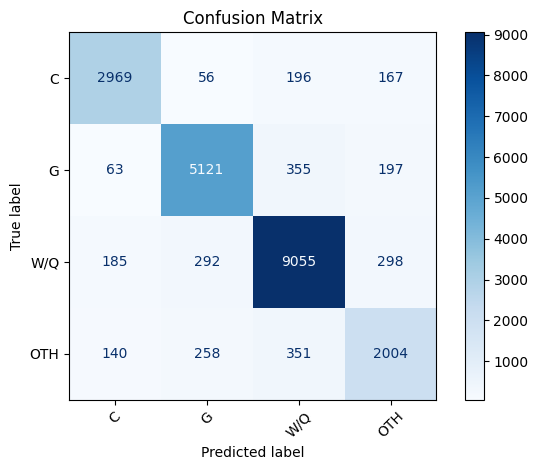

In [10]:
# Evaluation
# Run predictions
preds = trainer.predict(val_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(
    y_true,
    y_pred,
    labels=list(range(len(VALID_LABELS))),
    target_names=VALID_LABELS,
    zero_division=0
))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(VALID_LABELS))))
print("\nConfusion Matrix:\n", cm)

# Plot as heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=VALID_LABELS)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

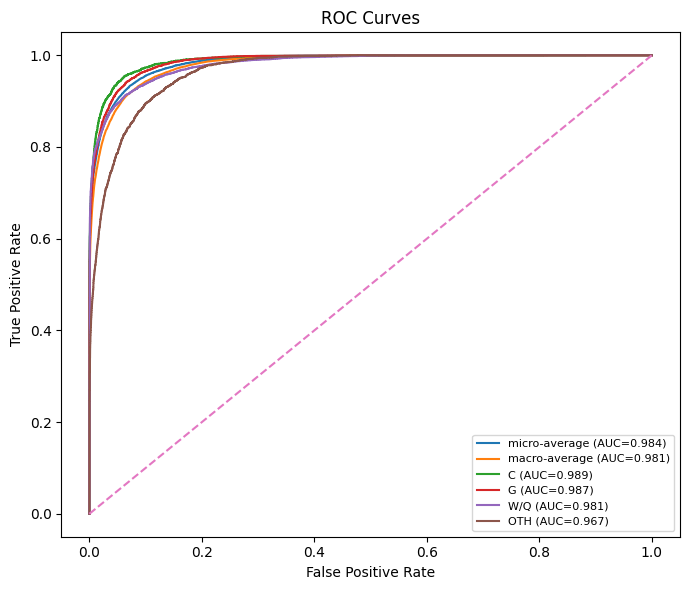

In [11]:
# ROC curves
logits = preds.predictions
probs = softmax(torch.tensor(logits), dim=-1).numpy()
y_true_bin = np.zeros((len(y_true), len(VALID_LABELS)), dtype=int)
for i, lbl in enumerate(y_true):
    y_true_bin[i, lbl] = 1

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(VALID_LABELS)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(VALID_LABELS))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(VALID_LABELS)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(VALID_LABELS)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(7, 6))
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC={roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], label=f"macro-average (AUC={roc_auc['macro']:.3f})")
for i in range(len(VALID_LABELS)):
    plt.plot(fpr[i], tpr[i], label=f"{VALID_LABELS[i]} (AUC={roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()

In [12]:
# Save model
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

('3_model/deepseek_qwen1p5b_qlora_cls\\tokenizer_config.json',
 '3_model/deepseek_qwen1p5b_qlora_cls\\special_tokens_map.json',
 '3_model/deepseek_qwen1p5b_qlora_cls\\chat_template.jinja',
 '3_model/deepseek_qwen1p5b_qlora_cls\\tokenizer.json')

In [8]:
# ---------- 1) Find debate/filename column & sample 40 debates ----------
filename_col = None
for cand in ["filename", "file_name", "debate_id", "doc", "source", "file", "topic_id"]:
    if cand in df.columns:
        filename_col = cand
        break
if filename_col is None:
    raise ValueError("No debate identifier column found. Add one of: "
                     "['filename','file_name','debate_id','doc','source','file','topic_id']")

unique_files = df[filename_col].dropna().unique().tolist()
rng = np.random.default_rng(42)
sampled_files = rng.choice(unique_files, size=min(100, len(unique_files)), replace=False).tolist()
df_sample = df[df[filename_col].isin(sampled_files)].copy()

In [9]:
print("\n=== SAMPLING SUMMARY ===")
print(f"Identifier column: {filename_col}")
print(f"Unique debates total: {len(unique_files)}")
print(f"Sampled debates: {len(sampled_files)}")
print(f"Sampled rows: {len(df_sample)}")
print("Sample label counts:", Counter(df_sample["label"]))
print("Sampled file examples:", sampled_files[:5])


=== SAMPLING SUMMARY ===
Identifier column: filename
Unique debates total: 3738
Sampled debates: 100
Sampled rows: 2931
Sample label counts: Counter({2: 1251, 1: 870, 0: 458, 3: 352})
Sampled file examples: ['YBA_661_mandatory-retirement_con_DJ_explicit.trs.txt', 'WS_3196_immigration-us_pro.trs.txt', 'SSH_3301_freedom-of-speech_con_DJ_implicit.trs.txt', 'RG_2143_ban-abortions_pro.trs.txt', 'JL_985_free-market_con_TL_implicit.trs.txt']


In [10]:
# ---------- 2) Split sampled subset & show shapes ----------
train_s, val_s = train_test_split(
    df_sample[[TEXT_COL, "label"]].copy(),
    test_size=0.2,
    stratify=df_sample["label"],
    random_state=42
)

In [11]:
print("\n=== SAMPLED SPLIT SHAPES ===")
print(f"train: {len(train_s)} | val: {len(val_s)}")
print("Train balance:", Counter(train_s["label"]))
print("Val balance:", Counter(val_s["label"]))


=== SAMPLED SPLIT SHAPES ===
train: 2344 | val: 587
Train balance: Counter({2: 1000, 1: 696, 0: 366, 3: 282})
Val balance: Counter({2: 251, 1: 174, 0: 92, 3: 70})


In [12]:
def make_hf_ds(train_df_in, val_df_in, max_length=256):
    def tok_fn(batch):
        return tokenizer(
            batch[TEXT_COL],
            truncation=True,
            max_length=max_length,
        )
    tr_ds = Dataset.from_pandas(train_df_in.reset_index(drop=True)).map(
        tok_fn, batched=True, remove_columns=[TEXT_COL]
    )
    va_ds = Dataset.from_pandas(val_df_in.reset_index(drop=True)).map(
        tok_fn, batched=True, remove_columns=[TEXT_COL]
    )
    return tr_ds, va_ds

In [13]:
# For memory hygiene between trials
def free_mem(obj_list):
    for o in obj_list:
        try:
            del o
        except:
            pass
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

In [14]:
# ---------- 3) Optuna objective (QLoRA) on sampled subset ----------
def objective(trial):
    # Search space
    lr            = trial.suggest_float("learning_rate", 5e-6, 5e-4, log=True)
    weight_decay  = trial.suggest_float("weight_decay", 0.0, 0.1)
    warmup_ratio  = trial.suggest_float("warmup_ratio", 0.0, 0.15)
    batch_size    = trial.suggest_categorical("per_device_train_batch_size", [4, 8])
    grad_accum    = trial.suggest_categorical("gradient_accumulation_steps", [1, 2, 4])
    max_length    = trial.suggest_categorical("max_length", [128, 192, 256, 320])
    num_epochs    = trial.suggest_categorical("num_train_epochs", [1, 2])  # short, fast

    # LoRA params
    lora_r        = trial.suggest_categorical("lora_r", [4, 8, 16])
    lora_alpha    = trial.suggest_categorical("lora_alpha", [8, 16, 32])
    lora_dropout  = trial.suggest_float("lora_dropout", 0.0, 0.1)

    tr_ds, va_ds = make_hf_ds(train_s, val_s, max_length=max_length)

    # Build fresh QLoRA model
    bf16_ok = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
    bnb_config_trial = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16 if bf16_ok else torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
    )
    off_dir = os.path.join(OUTPUT_DIR, f"offload_trial_{trial.number}")
    os.makedirs(off_dir, exist_ok=True)

    base = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=len(VALID_LABELS),
        quantization_config=bnb_config_trial,
        device_map="auto",
        trust_remote_code=True,
        offload_folder=off_dir,
    )
    base.config.pad_token_id = tokenizer.pad_token_id
    base = prepare_model_for_kbit_training(base)

    lcfg = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=lora_r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        bias="none",
        target_modules=[
            "q_proj", "k_proj", "v_proj", "o_proj",
            "gate_proj", "up_proj", "down_proj"
        ],
    )
    model_hpo = get_peft_model(base, lcfg)

    args = TrainingArguments(
        output_dir=os.path.join(OUTPUT_DIR, f"hpo_trial_{trial.number}"),
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,

        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=min(batch_size, 16),
        gradient_accumulation_steps=grad_accum,

        learning_rate=lr,
        weight_decay=weight_decay,
        num_train_epochs=num_epochs,
        warmup_ratio=warmup_ratio,

        fp16=(not bf16_ok) and torch.cuda.is_available(),
        bf16=bf16_ok,
        logging_steps=50,
        save_total_limit=1,
        report_to=[],  # keep external loggers off
    )

    trainer_hpo = Trainer(
        model=model_hpo,
        args=args,
        train_dataset=tr_ds,
        eval_dataset=va_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    try:
        trainer_hpo.train()
        metrics = trainer_hpo.evaluate(va_ds)
        score = metrics["eval_f1_macro"]
    except RuntimeError as e:
        # Handle occasional OOMs by returning a poor score
        print(f"[Trial {trial.number}] RuntimeError: {e}")
        score = 0.0

    # Cleanup
    free_mem([trainer_hpo, model_hpo, base, tr_ds, va_ds])

    return score

In [15]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, show_progress_bar=False)

[I 2025-09-15 15:45:50,035] A new study created in memory with name: no-name-ad0c2e47-59ec-4235-b5a5-68d067404bfb
Map: 100%|██████████| 587/587 [00:00<00:00, 29998.37 examples/s]
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 151646}.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,3.914500,0.753957,0.695060,0.649366
2,1.623800,0.696837,0.729131,0.699573


[I 2025-09-15 16:03:58,712] Trial 0 finished with value: 0.6995732201013574 and parameters: {'learning_rate': 0.000369300142326796, 'weight_decay': 0.04987460505955452, 'warmup_ratio': 0.09884061491307483, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 4, 'max_length': 256, 'num_train_epochs': 2, 'lora_r': 16, 'lora_alpha': 8, 'lora_dropout': 0.06519842630271083}. Best is trial 0 with value: 0.6995732201013574.
Map: 100%|██████████| 587/587 [00:00<00:00, 10373.41 examples/s]
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and gen

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.756000,0.977158,0.744463,0.703166
2,0.220900,0.870907,0.805792,0.760266


[I 2025-09-15 16:28:46,675] Trial 1 finished with value: 0.7602662442849624 and parameters: {'learning_rate': 0.00029903900929883776, 'weight_decay': 0.04458935431893464, 'warmup_ratio': 0.10849535763714907, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 1, 'max_length': 256, 'num_train_epochs': 2, 'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.08679485645656905}. Best is trial 1 with value: 0.7602662442849624.
Map: 100%|██████████| 587/587 [00:00<00:00, 6760.16 examples/s]
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and g

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.779600,0.662372,0.729131,0.698348


[I 2025-09-15 16:36:28,944] Trial 2 finished with value: 0.6983481708987062 and parameters: {'learning_rate': 0.0001404960120397559, 'weight_decay': 0.0167272530334162, 'warmup_ratio': 0.14825382873989004, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 1, 'max_length': 128, 'num_train_epochs': 1, 'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.00016298289894476348}. Best is trial 1 with value: 0.7602662442849624.
Map: 100%|██████████| 587/587 [00:00<00:00, 32604.41 examples/s]
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.549800,1.187607,0.480409,0.424046
2,2.084000,1.086036,0.538330,0.491075


[I 2025-09-15 16:45:53,461] Trial 3 finished with value: 0.4910749757361415 and parameters: {'learning_rate': 3.021412115901514e-05, 'weight_decay': 0.010619045650753134, 'warmup_ratio': 0.036456466545646805, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 2, 'max_length': 256, 'num_train_epochs': 2, 'lora_r': 16, 'lora_alpha': 16, 'lora_dropout': 0.059438709650110146}. Best is trial 1 with value: 0.7602662442849624.
Map: 100%|██████████| 587/587 [00:00<00:00, 38538.28 examples/s]
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config an

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.572400,1.199193,0.471891,0.421399


[I 2025-09-15 16:52:28,073] Trial 4 finished with value: 0.4213990781229151 and parameters: {'learning_rate': 2.6054722643041416e-05, 'weight_decay': 0.0991558224069729, 'warmup_ratio': 0.14422686206024765, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 2, 'max_length': 128, 'num_train_epochs': 1, 'lora_r': 4, 'lora_alpha': 8, 'lora_dropout': 0.05580727552807311}. Best is trial 1 with value: 0.7602662442849624.
Map: 100%|██████████| 587/587 [00:00<00:00, 23478.79 examples/s]
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and gen

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.902300,0.825696,0.681431,0.660494
2,0.442200,0.884647,0.722317,0.684196


[I 2025-09-15 17:14:23,950] Trial 5 finished with value: 0.6841962887490853 and parameters: {'learning_rate': 5.452399901571248e-05, 'weight_decay': 0.013470192283752925, 'warmup_ratio': 0.10129909389793358, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 1, 'max_length': 256, 'num_train_epochs': 2, 'lora_r': 4, 'lora_alpha': 32, 'lora_dropout': 0.019958146036485915}. Best is trial 1 with value: 0.7602662442849624.
Map: 100%|██████████| 587/587 [00:00<00:00, 9853.03 examples/s]
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and g

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.311500,1.191328,0.468484,0.417155


[I 2025-09-15 17:23:27,373] Trial 6 finished with value: 0.41715463922958984 and parameters: {'learning_rate': 9.422531933554203e-06, 'weight_decay': 0.051914081195789136, 'warmup_ratio': 0.08433656461796456, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 1, 'max_length': 256, 'num_train_epochs': 1, 'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.06840781348124646}. Best is trial 1 with value: 0.7602662442849624.
Map: 100%|██████████| 587/587 [00:00<00:00, 16758.03 examples/s]
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,4.495400,1.073807,0.546848,0.517898


[I 2025-09-15 17:32:02,551] Trial 7 finished with value: 0.5178976057864307 and parameters: {'learning_rate': 7.144018569908581e-05, 'weight_decay': 0.03951375201907297, 'warmup_ratio': 0.043917396920792585, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 4, 'max_length': 192, 'num_train_epochs': 1, 'lora_r': 16, 'lora_alpha': 16, 'lora_dropout': 0.09882204568903563}. Best is trial 1 with value: 0.7602662442849624.
Map: 100%|██████████| 587/587 [00:00<00:00, 25013.02 examples/s]
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and 

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.587700,1.265057,0.419080,0.352539


[I 2025-09-15 17:42:32,991] Trial 8 finished with value: 0.35253913271510107 and parameters: {'learning_rate': 1.884515013407498e-05, 'weight_decay': 0.06101264159582823, 'warmup_ratio': 0.14369175148089675, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 2, 'max_length': 256, 'num_train_epochs': 1, 'lora_r': 8, 'lora_alpha': 16, 'lora_dropout': 0.0329328563898069}. Best is trial 1 with value: 0.7602662442849624.
Map: 100%|██████████| 587/587 [00:00<00:00, 6418.04 examples/s]
Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and gen

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,8.494900,1.414586,0.361158,0.284017
2,5.453500,1.333498,0.403748,0.320296


[I 2025-09-15 17:55:22,249] Trial 9 finished with value: 0.32029580665442586 and parameters: {'learning_rate': 2.558442486638553e-05, 'weight_decay': 0.033171249106276744, 'warmup_ratio': 0.11785696986814453, 'per_device_train_batch_size': 8, 'gradient_accumulation_steps': 4, 'max_length': 320, 'num_train_epochs': 2, 'lora_r': 4, 'lora_alpha': 8, 'lora_dropout': 0.018319959979593226}. Best is trial 1 with value: 0.7602662442849624.


In [16]:
print("\n=== HPO BEST TRIAL ===")
print("Best f1_macro:", study.best_value)
print("Best params:", study.best_params)


=== HPO BEST TRIAL ===
Best f1_macro: 0.7602662442849624
Best params: {'learning_rate': 0.00029903900929883776, 'weight_decay': 0.04458935431893464, 'warmup_ratio': 0.10849535763714907, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 1, 'max_length': 256, 'num_train_epochs': 2, 'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.08679485645656905}


In [17]:
best = study.best_params.copy()
best_max_len = best.pop("max_length", 256)
_ = best.pop("num_train_epochs", None)

In [18]:
# ---------- 4) Final training on FULL dataset with best params ----------
train_full, val_full = train_test_split(
    df[[TEXT_COL, "label"]].copy(),
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

In [19]:
print("\n=== FULL SPLIT SHAPES ===")
print(f"train: {len(train_full)} | val: {len(val_full)}")
print("Train balance:", Counter(train_full["label"]))
print("Val balance:", Counter(val_full["label"]))


=== FULL SPLIT SHAPES ===
train: 86825 | val: 21707
Train balance: Counter({2: 39319, 1: 22944, 0: 13552, 3: 11010})
Val balance: Counter({2: 9830, 1: 5736, 0: 3388, 3: 2753})


In [20]:
train_ds_full, val_ds_full = make_hf_ds(train_full, val_full, max_length=best_max_len)

Map: 100%|██████████| 21707/21707 [00:01<00:00, 20547.45 examples/s]


In [21]:
# Fresh model w/ best LoRA hyperparams
bf16_ok = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
bnb_config_final = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16 if bf16_ok else torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)
OFFLOAD_DIR_FINAL = os.path.join(OUTPUT_DIR, "offload_final")
os.makedirs(OFFLOAD_DIR_FINAL, exist_ok=True)

In [22]:
base_final = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=len(VALID_LABELS),
    quantization_config=bnb_config_final,
    device_map="auto",
    trust_remote_code=True,
    offload_folder=OFFLOAD_DIR_FINAL,
)
base_final.config.pad_token_id = tokenizer.pad_token_id
base_final = prepare_model_for_kbit_training(base_final)

Some weights of Qwen2ForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
lcfg_final = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=best.get("lora_r", 8),
    lora_alpha=best.get("lora_alpha", 16),
    lora_dropout=best.get("lora_dropout", 0.05),
    bias="none",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj"
    ],
)
model_final = get_peft_model(base_final, lcfg_final)
model_final.print_trainable_parameters()

trainable params: 18,470,912 || all params: 1,562,191,360 || trainable%: 1.1824


In [24]:
final_epochs = 3

final_args = TrainingArguments(
    output_dir=os.path.join(OUTPUT_DIR, "final_best"),
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    per_device_train_batch_size=best.get("per_device_train_batch_size", 8),
    per_device_eval_batch_size=min(best.get("per_device_train_batch_size", 8), 16),
    gradient_accumulation_steps=best.get("gradient_accumulation_steps", 2),

    learning_rate=best.get("learning_rate", 2e-5),
    weight_decay=best.get("weight_decay", 0.05),
    warmup_ratio=best.get("warmup_ratio", 0.0),

    num_train_epochs=final_epochs,
    fp16=(not bf16_ok) and torch.cuda.is_available(),
    bf16=bf16_ok,

    logging_dir=os.path.join(OUTPUT_DIR, "final_best", "logs"),
    logging_steps=100,
    save_total_limit=2,
    report_to=[],
)

In [25]:
trainer_final = Trainer(
    model=model_final,
    args=final_args,
    train_dataset=train_ds_full,
    eval_dataset=val_ds_full,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

In [26]:
trainer_final.train()

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 151646}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.439800,0.420502,0.849726,0.816477
2,0.337100,0.382693,0.877689,0.850030
3,0.253200,0.344611,0.897222,0.872568


TrainOutput(global_step=65121, training_loss=0.42971302107217, metrics={'train_runtime': 47926.8015, 'train_samples_per_second': 5.435, 'train_steps_per_second': 1.359, 'total_flos': 1.0772518569546547e+17, 'train_loss': 0.42971302107217, 'epoch': 3.0})

In [27]:
# ---------- 5) Evaluation on full val ----------
preds_final = trainer_final.predict(val_ds_full)
y_true_final = preds_final.label_ids
y_pred_final = np.argmax(preds_final.predictions, axis=1)

print("\n=== FINAL CLASSIFICATION REPORT ===")
print(classification_report(
    y_true_final,
    y_pred_final,
    labels=list(range(len(VALID_LABELS))),
    target_names=VALID_LABELS,
    zero_division=0
))


=== FINAL CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           C       0.90      0.89      0.90      3388
           G       0.89      0.93      0.91      5736
         W/Q       0.94      0.92      0.93      9830
         OTH       0.76      0.75      0.76      2753

    accuracy                           0.90     21707
   macro avg       0.87      0.87      0.87     21707
weighted avg       0.90      0.90      0.90     21707




Confusion Matrix:
 [[3031   61  139  157]
 [  57 5307  208  164]
 [ 138  292 9068  332]
 [ 157  299  227 2070]]


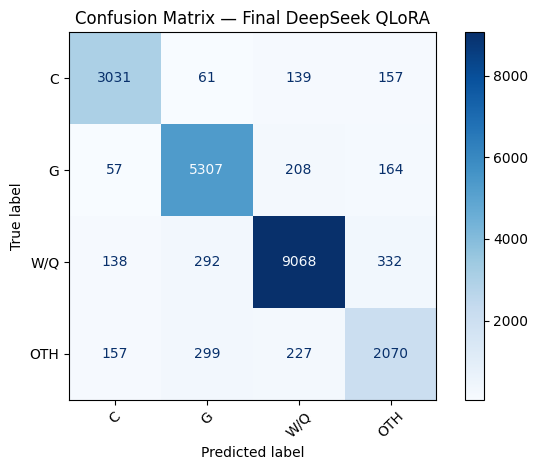

In [28]:
cm_final = confusion_matrix(y_true_final, y_pred_final,
                            labels=list(range(len(VALID_LABELS))))
print("\nConfusion Matrix:\n", cm_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=VALID_LABELS)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix — Final DeepSeek QLoRA")
plt.tight_layout()
plt.show()

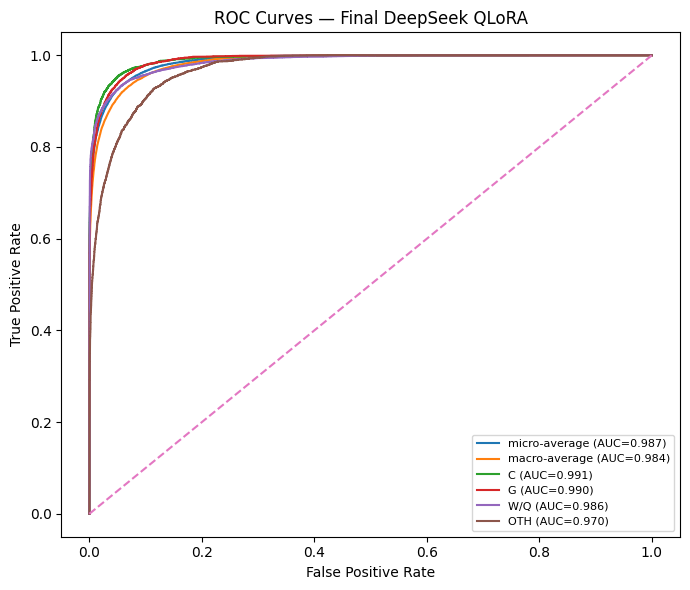

In [29]:
# ---------- 6) ROC curves ----------
logits = preds_final.predictions
probs = softmax(torch.tensor(logits), dim=-1).numpy()
y_true_bin = np.zeros((len(y_true_final), len(VALID_LABELS)), dtype=int)
for i, lbl in enumerate(y_true_final):
    y_true_bin[i, lbl] = 1

fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(VALID_LABELS)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(VALID_LABELS))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(VALID_LABELS)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(VALID_LABELS)
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(7, 6))
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC={roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], label=f"macro-average (AUC={roc_auc['macro']:.3f})")
for i in range(len(VALID_LABELS)):
    plt.plot(fpr[i], tpr[i], label=f"{VALID_LABELS[i]} (AUC={roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Final DeepSeek QLoRA")
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()

In [30]:
# ---------- 7) Save best model ----------
BEST_DIR = os.path.join(OUTPUT_DIR, "best")
trainer_final.save_model(BEST_DIR)
tokenizer.save_pretrained(BEST_DIR)
print(f"\nSaved final best model to: {BEST_DIR}")
print("Best HPO params used:", {**best, "max_length": best_max_len, "final_epochs": final_epochs})


Saved final best model to: 3_model/deepseek_qwen1p5b_qlora_cls\best
Best HPO params used: {'learning_rate': 0.00029903900929883776, 'weight_decay': 0.04458935431893464, 'warmup_ratio': 0.10849535763714907, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 1, 'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.08679485645656905, 'max_length': 256, 'final_epochs': 3}
